In [351]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [352]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [353]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import re
import networkx as nx

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
# from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
from analysis.dataframes2 import *
# from analysis.volumes import *
from helpers.ep_helpers import WallNormal
import math
from itertools import product
from analysis.cp_eq import calc_cp

from typing import NamedTuple


sns.set_style("darkgrid")

In [354]:
cases = retrieve_cases()

In [447]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "bol" in i.case_name]
case

CaseData(case_name='Medium_case_bol_5', idf=<geomeppy.idf.IDF object at 0x17e4bc610>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5'))

In [448]:
wind_dirs = [i*0.5 for i in range(721)]

In [449]:
def compute_incident_wind_dir_angle(wall_normal, wind_dir):
    res = wind_dir - wall_normal
    inc_angle = 360 - res if res > 180 else res # hmmm... 
    return inc_angle
    

In [450]:
side_ratio_map = {
    "NORTH": math.log(8/5),
    "SOUTH": math.log(8/5),
    "EAST": math.log(5/8),
    "WEST": math.log(5/6),
}

class AngleSurfacePair(NamedTuple):
    wall_normal: WallNormal
    wind_dir: float

class IncidentAngleData(NamedTuple):
    wall_normal_name: str
    wind_dir: float
    incident_angle: float

    @property
    def side_ratio_fac(self):
        return side_ratio_map[self.wall_normal_name]


In [451]:
side_ratio_map = {
    "NORTH": math.log(8/5),
    "SOUTH": math.log(8/5),
    "EAST": math.log(5/8),
    "WEST": math.log(5/6),
}

In [452]:
angles_data =[ AngleSurfacePair(*j) for j in product([i for i in WallNormal], wind_dirs)]
incident_angles = [IncidentAngleData(i.wall_normal.name, i.wind_dir, compute_incident_wind_dir_angle(i.wall_normal.value, i.wind_dir)) for i in angles_data]
cps = [calc_cp(i.incident_angle) for i in incident_angles]
df = pl.DataFrame(data= {
    "wall_normal": [i.wall_normal_name for i in incident_angles],
    "wind_dir": [i.wind_dir for i in incident_angles],
    "incident_angle": [i.incident_angle for i in incident_angles],
    "cp": [calc_cp(i.incident_angle,i.side_ratio_fac) for i in incident_angles]
})
df

wall_normal,wind_dir,incident_angle,cp
str,f64,f64,f64
"""NORTH""",0.0,0.0,0.603459
"""NORTH""",0.5,0.5,0.602762
"""NORTH""",1.0,1.0,0.602015
"""NORTH""",1.5,1.5,0.601219
"""NORTH""",2.0,2.0,0.600373
…,…,…,…
"""WEST""",358.0,88.0,-0.425866
"""WEST""",358.5,88.5,-0.436428
"""WEST""",359.0,89.0,-0.44696


In [453]:
# df = df.with_columns(adj_wind_dir=pl.when(pl.col("wind_dir") > 180).then(180 - pl.col("wind_dir") ).otherwise(pl.col("wind_dir") ))
# df.head()

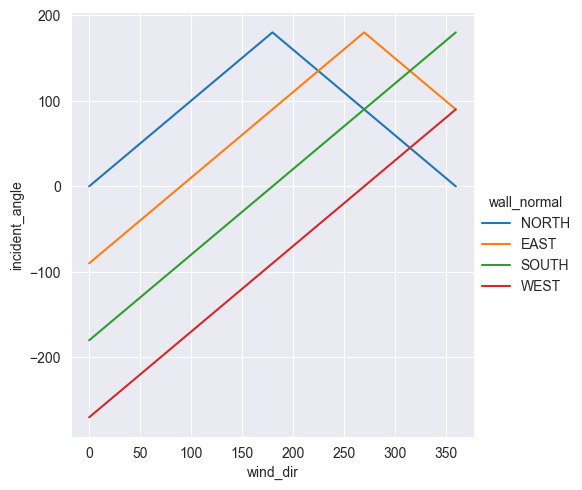

In [454]:
sns.relplot(df, x="wind_dir", y="incident_angle", hue="wall_normal", kind="line")

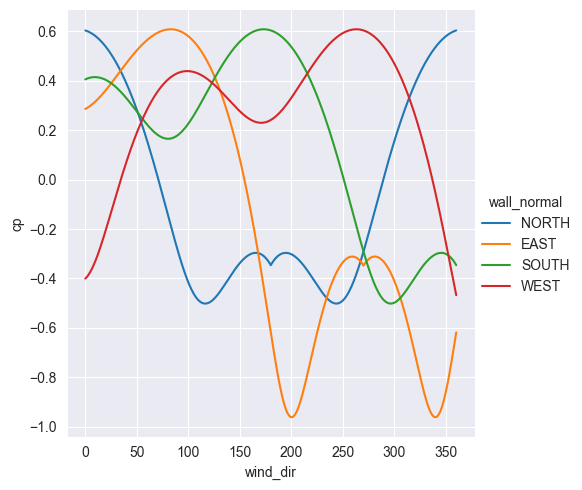

In [455]:
sns.relplot(df, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [456]:
df_pressure = get_external_node_df(case)
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg]
str,str,datetime[μs],f64,f64,f64
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:00:00,0.130645,1.425,305.0
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:15:00,0.134441,1.35,300.0
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:30:00,0.126161,1.275,295.0
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:45:00,0.117332,1.2,290.0
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 01:00:00,0.107801,1.15,290.0
…,…,…,…,…,…
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 22:45:00,-0.245771,1.8,310.0
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 23:00:00,-0.225825,1.725,310.0
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 23:15:00,-0.206715,1.65,310.0


In [457]:
df_pressure = df_pressure.with_columns(wind_val= 2/(pl.col("Site Wind Speed [m/s]"))**2)
rho = 1.225 # kg/m3
df_pressure = df_pressure.with_columns(cp_val=pl.col("AFN Node Wind Pressure [Pa]")*pl.col("wind_val")/rho)  # divide by air density? 
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg],wind_val,cp_val
str,str,datetime[μs],f64,f64,f64,f64,f64
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:00:00,0.130645,1.425,305.0,0.984918,0.105041
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:15:00,0.134441,1.35,300.0,1.097394,0.120436
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:30:00,0.126161,1.275,295.0,1.230296,0.126706
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 00:45:00,0.117332,1.2,290.0,1.388889,0.133029
"""Medium_case_bol_5""","""ExtNode 3""",2017-07-01 01:00:00,0.107801,1.15,290.0,1.512287,0.133082
…,…,…,…,…,…,…,…
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 22:45:00,-0.245771,1.8,310.0,0.617284,-0.123845
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 23:00:00,-0.225825,1.725,310.0,0.672128,-0.123905
"""Medium_case_bol_5""","""ExtNode 1""",2017-07-01 23:15:00,-0.206715,1.65,310.0,0.734619,-0.123964


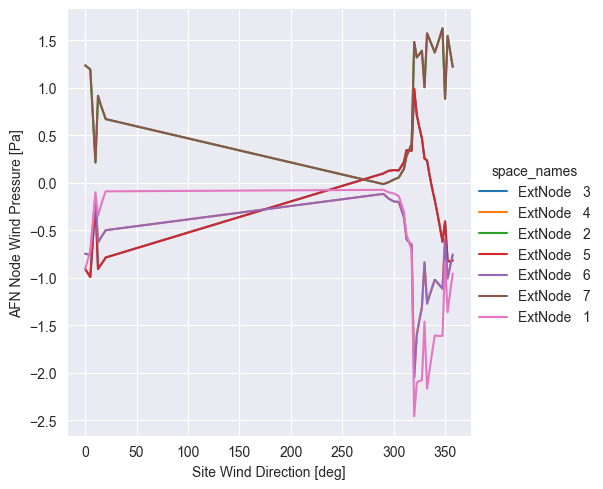

In [458]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="AFN Node Wind Pressure [Pa]", hue="space_names", kind="line", errorbar=None)

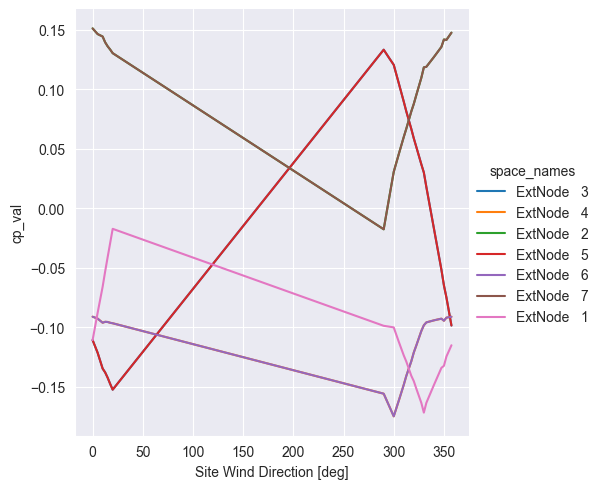

In [459]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="cp_val", hue="space_names", kind="line", errorbar=None)

In [460]:
exp_wind_dirs = list(df_pressure["Site Wind Direction [deg]"].unique())
len(exp_wind_dirs)

31

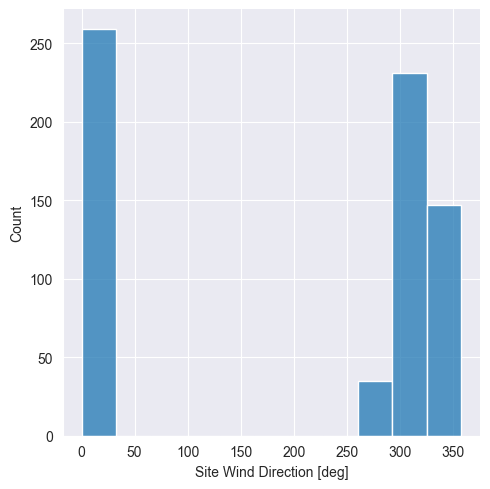

In [461]:
sns.displot(df_pressure, x="Site Wind Direction [deg]")

In [462]:
df_filtered = df.filter(pl.col("wind_dir").is_in(exp_wind_dirs))

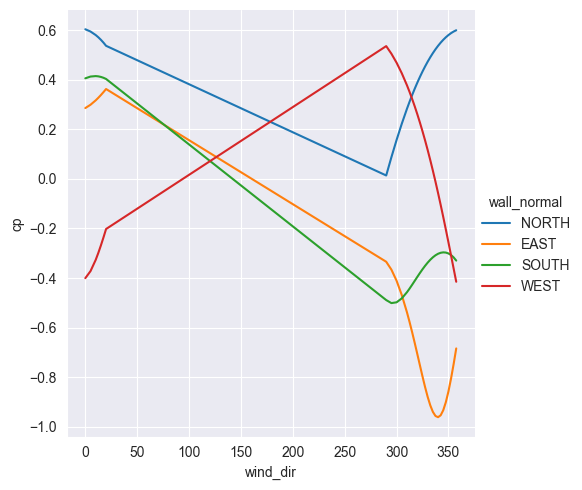

In [463]:
sns.relplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [464]:
df_an = df_filtered.pivot("wall_normal", index="wind_dir", values="cp")
df_an = df_an.rename({"wind_dir": "Site Wind Direction [deg]"})
df_an.head(2)

Site Wind Direction [deg],NORTH,EAST,SOUTH,WEST
f64,f64,f64,f64,f64
0.0,0.603459,0.285501,0.405479,-0.400756
5.0,0.594263,0.298877,0.412654,-0.372372


In [465]:
df_exp = df_pressure.pivot("space_names", index=["datetimes", "Site Wind Direction [deg]"], values="cp_val",)
df_exp.head(2)

datetimes,Site Wind Direction [deg],ExtNode 3,ExtNode 4,ExtNode 2,ExtNode 5,ExtNode 6,ExtNode 7,ExtNode 1
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,305.0,0.105041,-0.161774,0.045335,0.105041,-0.161774,0.045335,-0.112159
2017-07-01 00:15:00,300.0,0.120436,-0.174858,0.030527,0.120436,-0.174858,0.030527,-0.100146


<Axes: xlabel='Site Wind Direction [deg]', ylabel='Count'>

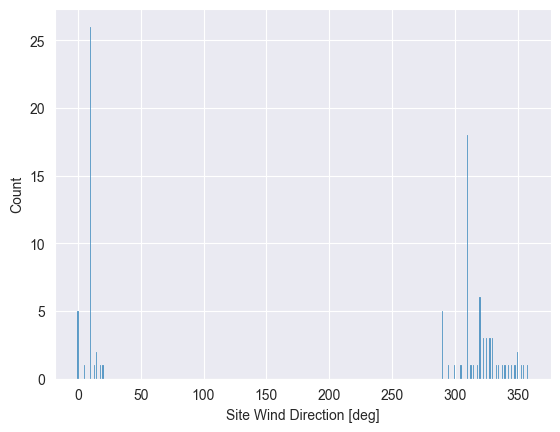

In [466]:
sns.histplot(df_exp, x="Site Wind Direction [deg]", discrete=True, )

In [467]:
df_exp["Site Wind Direction [deg]"].unique()

Site Wind Direction [deg]
f64
0.0
5.0
10.0
12.5
15.0
…
347.5
350.0
352.5


In [468]:
def find_corr_pair(col_a, col_b):
    res = df_exp.select(pl.corr(col_a, col_b , method="spearman"))
    assert not (res[col_a].is_nan()).all()
    corr = res[col_a].to_list()[0]
    if corr == 1:
            return(col_a, col_b)
    return None

ext_cols = sorted(df_exp.select(cs.contains("Ext")).columns)
pairs = list(product(ext_cols, ext_cols))

corrs = [find_corr_pair(*p) for p in pairs]



In [469]:
filtered_corrs = [tuple(sorted(i)) for i in corrs if i]
unique_corrs = list(set(filtered_corrs))
G=nx.from_edgelist(unique_corrs)
l=list(nx.connected_components(G))
independent_nodes = sorted([list(i)[0] for i in l])
independent_nodes


['ExtNode   1', 'ExtNode   3', 'ExtNode   6', 'ExtNode   7']

In [470]:
df_ind = df_exp.select(["Site Wind Direction [deg]"] + independent_nodes)
df_ind = df_ind.select(pl.col("*").fill_nan(None)).drop_nulls()
df_ind.head(), df_ind.shape

(shape: (5, 5)
 ┌───────────────────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
 │ Site Wind Direction [deg] ┆ ExtNode   1 ┆ ExtNode   3 ┆ ExtNode   6 ┆ ExtNode   7 │
 │ ---                       ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
 │ f64                       ┆ f64         ┆ f64         ┆ f64         ┆ f64         │
 ╞═══════════════════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
 │ 305.0                     ┆ -0.112159   ┆ 0.105041    ┆ -0.161774   ┆ 0.045335    │
 │ 300.0                     ┆ -0.100146   ┆ 0.120436    ┆ -0.174858   ┆ 0.030527    │
 │ 295.0                     ┆ -0.099443   ┆ 0.126706    ┆ -0.165324   ┆ 0.006507    │
 │ 290.0                     ┆ -0.098737   ┆ 0.133029    ┆ -0.155719   ┆ -0.017704   │
 │ 290.0                     ┆ -0.098776   ┆ 0.133082    ┆ -0.15578    ┆ -0.017711   │
 └───────────────────────────┴─────────────┴─────────────┴─────────────┴─────────────┘,
 (95, 5))

In [471]:
# with pl.Config(tbl_rows=100):
#     print(df_ind.sort(by="Site Wind Direction [deg]"))

In [472]:
df_ind_agg = df_ind.group_by("Site Wind Direction [deg]").mean()
df_ind_agg.sort(by="Site Wind Direction [deg]")

Site Wind Direction [deg],ExtNode 1,ExtNode 3,ExtNode 6,ExtNode 7
f64,f64,f64,f64,f64
0.0,-0.110804,-0.110804,-0.091157,0.151049
5.0,-0.087892,-0.121433,-0.092764,0.14628
10.0,-0.06597,-0.13476,-0.096226,0.144207
12.5,-0.053152,-0.137962,-0.095451,0.139374
15.0,-0.041071,-0.142435,-0.095608,0.135966
…,…,…,…,…
347.5,-0.134133,-0.051676,-0.092802,0.135505
350.0,-0.132425,-0.064827,-0.094558,0.141708
352.5,-0.124603,-0.075016,-0.091956,0.141387


<Axes: xlabel='Site Wind Direction [deg]', ylabel='ExtNode   3'>

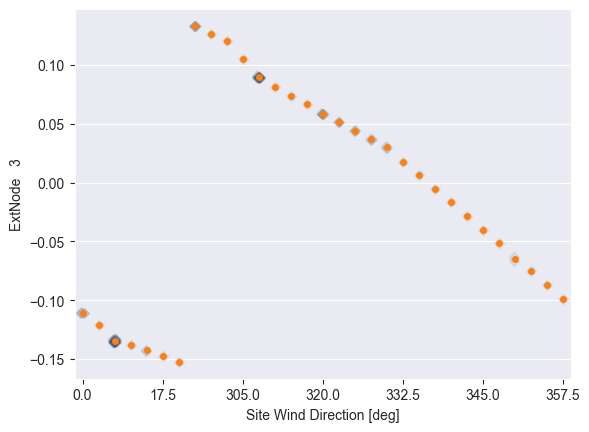

In [473]:
g = sns.stripplot(data=df_ind, x="Site Wind Direction [deg]", y="ExtNode   3", marker="D", linewidth=1, alpha=.1,)
sns.stripplot(df_ind_agg, x="Site Wind Direction [deg]", y="ExtNode   3")
set_axis_ticks(g)

In [474]:
df_join = df_ind_agg.join(df_an, on=["Site Wind Direction [deg]"])
dir_cols = [i.name for i in WallNormal]
df_join.head(2), df_join.shape


(shape: (2, 9)
 ┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬──────────┬───────────┐
 │ Site Wind  ┆ ExtNode    ┆ ExtNode   ┆ ExtNode   ┆ … ┆ NORTH    ┆ EAST     ┆ SOUTH    ┆ WEST      │
 │ Direction  ┆ 1          ┆ 3         ┆ 6         ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
 │ [deg]      ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
 │ ---        ┆ f64        ┆ f64       ┆ f64       ┆   ┆          ┆          ┆          ┆           │
 │ f64        ┆            ┆           ┆           ┆   ┆          ┆          ┆          ┆           │
 ╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪══════════╪═══════════╡
 │ 0.0        ┆ -0.110804  ┆ -0.110804 ┆ -0.091157 ┆ … ┆ 0.603459 ┆ 0.285501 ┆ 0.405479 ┆ -0.400756 │
 │ 5.0        ┆ -0.087892  ┆ -0.121433 ┆ -0.092764 ┆ … ┆ 0.594263 ┆ 0.298877 ┆ 0.412654 ┆ -0.372372 │
 └────────────┴────────────┴───────────┴───────────┴───┴──────────┴

In [475]:
def get_dif(col_a, col_b):
    return (df_join[col_a] - df_join[col_b]).alias(f"{col_a}__{col_b}")

ext_cols = sorted(df_ind.select(cs.contains("Ext")).columns)
col_pairs = list(product(ext_cols, dir_cols))
difs = [get_dif(*p) for p in col_pairs]
df_diff = pl.DataFrame(difs)
df_diff.insert_column(0, df_join["Site Wind Direction [deg]"])
df_diff


Site Wind Direction [deg],ExtNode 1__NORTH,ExtNode 1__EAST,ExtNode 1__SOUTH,ExtNode 1__WEST,ExtNode 3__NORTH,ExtNode 3__EAST,ExtNode 3__SOUTH,ExtNode 3__WEST,ExtNode 6__NORTH,ExtNode 6__EAST,ExtNode 6__SOUTH,ExtNode 6__WEST,ExtNode 7__NORTH,ExtNode 7__EAST,ExtNode 7__SOUTH,ExtNode 7__WEST
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-0.714263,-0.396305,-0.516283,0.289952,-0.714263,-0.396305,-0.516283,0.289952,-0.694616,-0.376658,-0.496636,0.309599,-0.45241,-0.134451,-0.25443,0.551805
5.0,-0.682156,-0.38677,-0.500546,0.284479,-0.715697,-0.420311,-0.534087,0.250938,-0.687027,-0.391641,-0.505418,0.279608,-0.447983,-0.152597,-0.266373,0.518652
10.0,-0.646072,-0.382555,-0.480451,0.260979,-0.714862,-0.451345,-0.549241,0.192189,-0.676328,-0.412811,-0.510708,0.230723,-0.435896,-0.172378,-0.270275,0.471156
12.5,-0.624295,-0.380025,-0.466601,0.246005,-0.709106,-0.464835,-0.551412,0.161195,-0.666595,-0.422324,-0.508901,0.203706,-0.43177,-0.1875,-0.274076,0.43853
15.0,-0.601995,-0.379066,-0.452227,0.227691,-0.703359,-0.48043,-0.553591,0.126327,-0.656533,-0.433603,-0.506765,0.173153,-0.424959,-0.202029,-0.275191,0.404727
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
347.5,-0.705277,0.766677,0.163412,0.070641,-0.62282,0.849134,0.245868,0.153098,-0.663946,0.808009,0.204743,0.111973,-0.435638,1.036316,0.43305,0.34028
350.0,-0.712527,0.725142,0.168644,0.124033,-0.644929,0.79274,0.236242,0.191631,-0.674661,0.763009,0.20651,0.1619,-0.438394,0.999275,0.442776,0.398166
352.5,-0.712409,0.681057,0.182876,0.184428,-0.662822,0.730644,0.232463,0.234015,-0.679763,0.713703,0.215522,0.217074,-0.44642,0.947047,0.448865,0.450418


In [476]:
df_diff_long = df_diff.unpivot(index="Site Wind Direction [deg]")
df_diff_long = df_diff_long.with_columns(split_names=pl.col("variable").str.split(by="__"))
df_diff_long

Site Wind Direction [deg],variable,value,split_names
f64,str,f64,list[str]
0.0,"""ExtNode 1__NORTH""",-0.714263,"[""ExtNode 1"", ""NORTH""]"
5.0,"""ExtNode 1__NORTH""",-0.682156,"[""ExtNode 1"", ""NORTH""]"
10.0,"""ExtNode 1__NORTH""",-0.646072,"[""ExtNode 1"", ""NORTH""]"
12.5,"""ExtNode 1__NORTH""",-0.624295,"[""ExtNode 1"", ""NORTH""]"
15.0,"""ExtNode 1__NORTH""",-0.601995,"[""ExtNode 1"", ""NORTH""]"
…,…,…,…
347.5,"""ExtNode 7__WEST""",0.34028,"[""ExtNode 7"", ""WEST""]"
350.0,"""ExtNode 7__WEST""",0.398166,"[""ExtNode 7"", ""WEST""]"
352.5,"""ExtNode 7__WEST""",0.450418,"[""ExtNode 7"", ""WEST""]"


In [477]:
df_diff_long = df_diff_long.lazy().with_columns([
    pl.col("split_names").list.get(pl.lit(0)).alias("node"),
    pl.col("split_names").list.get(pl.lit(1)).alias("drn")
]).collect()
df_diff2 = df_diff_long.drop(["variable", "split_names"])
df_diff2


Site Wind Direction [deg],value,node,drn
f64,f64,str,str
0.0,-0.714263,"""ExtNode 1""","""NORTH"""
5.0,-0.682156,"""ExtNode 1""","""NORTH"""
10.0,-0.646072,"""ExtNode 1""","""NORTH"""
12.5,-0.624295,"""ExtNode 1""","""NORTH"""
15.0,-0.601995,"""ExtNode 1""","""NORTH"""
…,…,…,…
347.5,0.34028,"""ExtNode 7""","""WEST"""
350.0,0.398166,"""ExtNode 7""","""WEST"""
352.5,0.450418,"""ExtNode 7""","""WEST"""


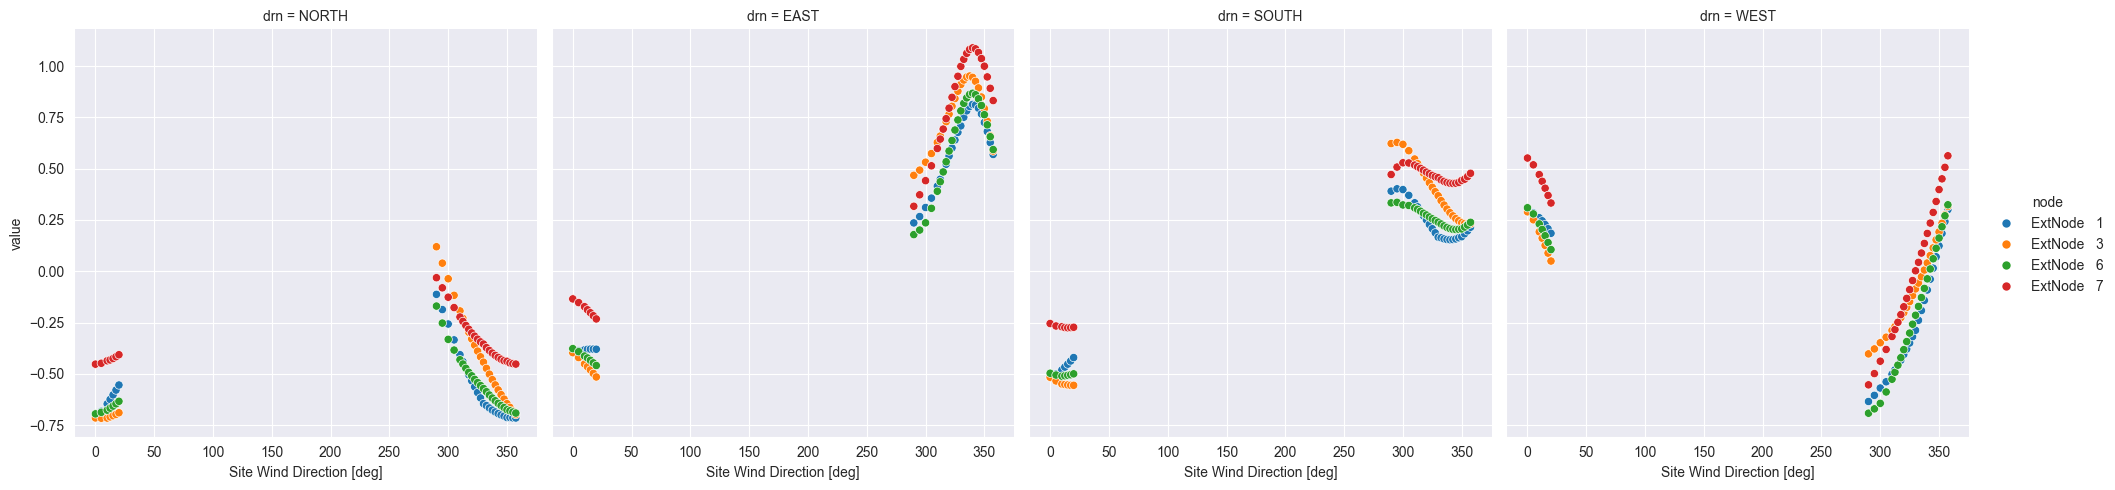

In [478]:
sns.relplot(df_diff2, x="Site Wind Direction [deg]", y="value", col="drn", hue="node")

In [479]:
df_join.with_columns((pl.col("ExtNode   3") - pl.col("SOUTH")).alias("test") )

Site Wind Direction [deg],ExtNode 1,ExtNode 3,ExtNode 6,ExtNode 7,NORTH,EAST,SOUTH,WEST,test
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-0.110804,-0.110804,-0.091157,0.151049,0.603459,0.285501,0.405479,-0.400756,-0.516283
5.0,-0.087892,-0.121433,-0.092764,0.14628,0.594263,0.298877,0.412654,-0.372372,-0.534087
10.0,-0.06597,-0.13476,-0.096226,0.144207,0.580102,0.316585,0.414482,-0.326949,-0.549241
12.5,-0.053152,-0.137962,-0.095451,0.139374,0.571144,0.326873,0.413449,-0.299157,-0.551412
15.0,-0.041071,-0.142435,-0.095608,0.135966,0.560925,0.337995,0.411157,-0.268761,-0.553591
…,…,…,…,…,…,…,…,…,…
347.5,-0.134133,-0.051676,-0.092802,0.135505,0.571144,-0.900811,-0.297545,-0.204775,0.245868
350.0,-0.132425,-0.064827,-0.094558,0.141708,0.580102,-0.857567,-0.301068,-0.256458,0.236242
352.5,-0.124603,-0.075016,-0.091956,0.141387,0.587807,-0.80566,-0.307478,-0.309031,0.232463


In [480]:
df_join = df_ind.join(df_an, on=["Site Wind Direction [deg]"])
df_join.head(2)
dir_cols = [i.name for i in WallNormal]

In [481]:
df_ind_long = df_ind.unpivot(index=["Site Wind Direction [deg]"], variable_name="ExtNode", value_name="Calc_Cp")
df_ind_long.head()

Site Wind Direction [deg],ExtNode,Calc_Cp
f64,str,f64
305.0,"""ExtNode 1""",-0.112159
300.0,"""ExtNode 1""",-0.100146
295.0,"""ExtNode 1""",-0.099443
290.0,"""ExtNode 1""",-0.098737
290.0,"""ExtNode 1""",-0.098776


In [482]:
df_an_long = df_an.unpivot(index=["Site Wind Direction [deg]"], variable_name="WallNormal", value_name="AnalyticalCp")
df_an_long.head()

Site Wind Direction [deg],WallNormal,AnalyticalCp
f64,str,f64
0.0,"""NORTH""",0.603459
5.0,"""NORTH""",0.594263
10.0,"""NORTH""",0.580102
12.5,"""NORTH""",0.571144
15.0,"""NORTH""",0.560925


In [483]:
df_res = df_ind_long.join(df_an_long, on=["Site Wind Direction [deg]"])
df_res

Site Wind Direction [deg],ExtNode,Calc_Cp,WallNormal,AnalyticalCp
f64,str,f64,str,f64
305.0,"""ExtNode 1""",-0.112159,"""NORTH""",0.222029
305.0,"""ExtNode 1""",-0.112159,"""EAST""",-0.468639
305.0,"""ExtNode 1""",-0.112159,"""SOUTH""",-0.482394
305.0,"""ExtNode 1""",-0.112159,"""WEST""",0.426124
300.0,"""ExtNode 1""",-0.100146,"""NORTH""",0.156744
…,…,…,…,…
310.0,"""ExtNode 7""",0.060001,"""WEST""",0.377488
310.0,"""ExtNode 7""",0.06003,"""NORTH""",0.282482
310.0,"""ExtNode 7""",0.06003,"""EAST""",-0.538367


/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_33519/678487851.py:1: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(df_ind_long, x="Site Wind Direction [deg]", y="Calc_Cp", hue="ExtNode", markers=True, style="ExtNode", palette=sns.dark_palette("#69d"))
/var/folders/7r/39t1cgb13d57zk26c__2z50m0000gn/T/ipykernel_33519/678487851.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", palette=sns.color_palette("YlOrBr"), dashes=True, markers=True, style="wall_normal")


<Axes: xlabel='Site Wind Direction [deg]', ylabel='Calc_Cp'>

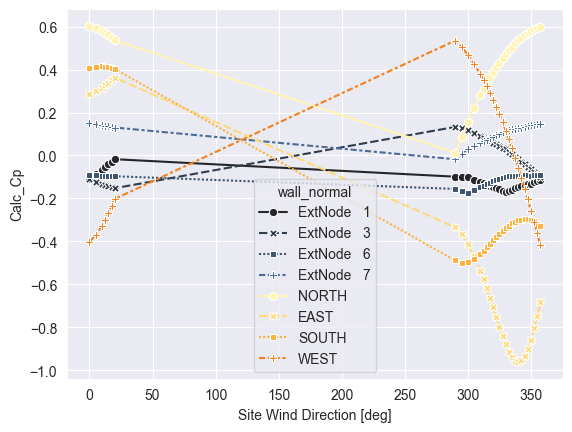

In [484]:
sns.lineplot(df_ind_long, x="Site Wind Direction [deg]", y="Calc_Cp", hue="ExtNode", markers=True, style="ExtNode", palette=sns.dark_palette("#69d"))
# sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")
cmap = sns.color_palette("rocket")
sns.lineplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", palette=sns.color_palette("YlOrBr"), dashes=True, markers=True, style="wall_normal")

In [485]:
# maybe have the same change points.. 

In [486]:
corr = df_join.drop("Site Wind Direction [deg]").to_pandas().corr()
corr

,ExtNode 1,ExtNode 3,ExtNode 6,ExtNode 7,NORTH,EAST,SOUTH,WEST
ExtNode 1,1.000000,-0.685320,0.255940,0.322072,0.319977,0.916262,0.795481,-0.562377
ExtNode 3,-0.685320,1.000000,-0.860890,-0.898029,-0.897864,-0.747944,-0.937365,0.981307
ExtNode 6,0.255940,-0.860890,1.000000,0.940340,0.944921,0.368820,0.708456,-0.903150
ExtNode 7,0.322072,-0.898029,0.940340,1.000000,0.998910,0.444810,0.757046,-0.931104
NORTH,0.319977,-0.897864,0.944921,0.998910,1.000000,0.434428,0.750109,-0.932276
EAST,0.916262,-0.747944,0.368820,0.444810,0.434428,1.000000,0.912402,-0.651629
SOUTH,0.795481,-0.937365,0.708456,0.757046,0.750109,0.912402,1.000000,-0.880356
WEST,-0.562377,0.981307,-0.903150,-0.931104,-0.932276,-0.651629,-0.880356,1.000000


In [487]:
corr = corr.iloc[0:4, 4:]
corr

,NORTH,EAST,SOUTH,WEST
ExtNode 1,0.319977,0.916262,0.795481,-0.562377
ExtNode 3,-0.897864,-0.747944,-0.937365,0.981307
ExtNode 6,0.944921,0.368820,0.708456,-0.903150
ExtNode 7,0.998910,0.444810,0.757046,-0.931104


<Axes: >

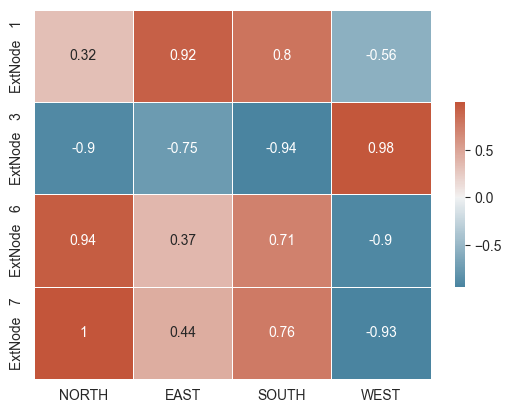

In [ ]:
corr = df_join.drop("Site Wind Direction [deg]").to_pandas().corr()
corr = corr.iloc[0:4, 4:]

# Set up the matplotlib figure
f, ax = plt.subplots()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,  cmap=cmap, center=0,
             linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# multiplu by regression coeff maybe? 

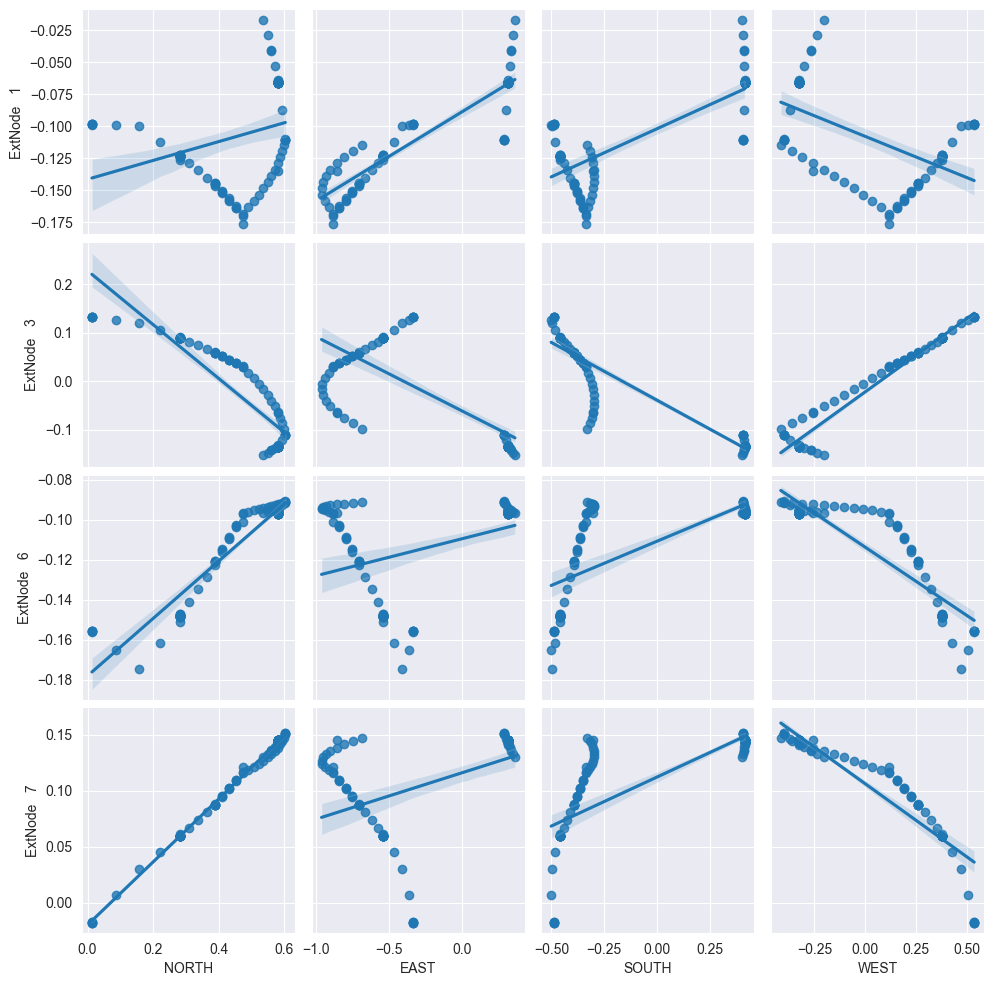

In [489]:
sns.pairplot(df_join.to_pandas(), x_vars=dir_cols, y_vars=ext_cols, kind="reg")

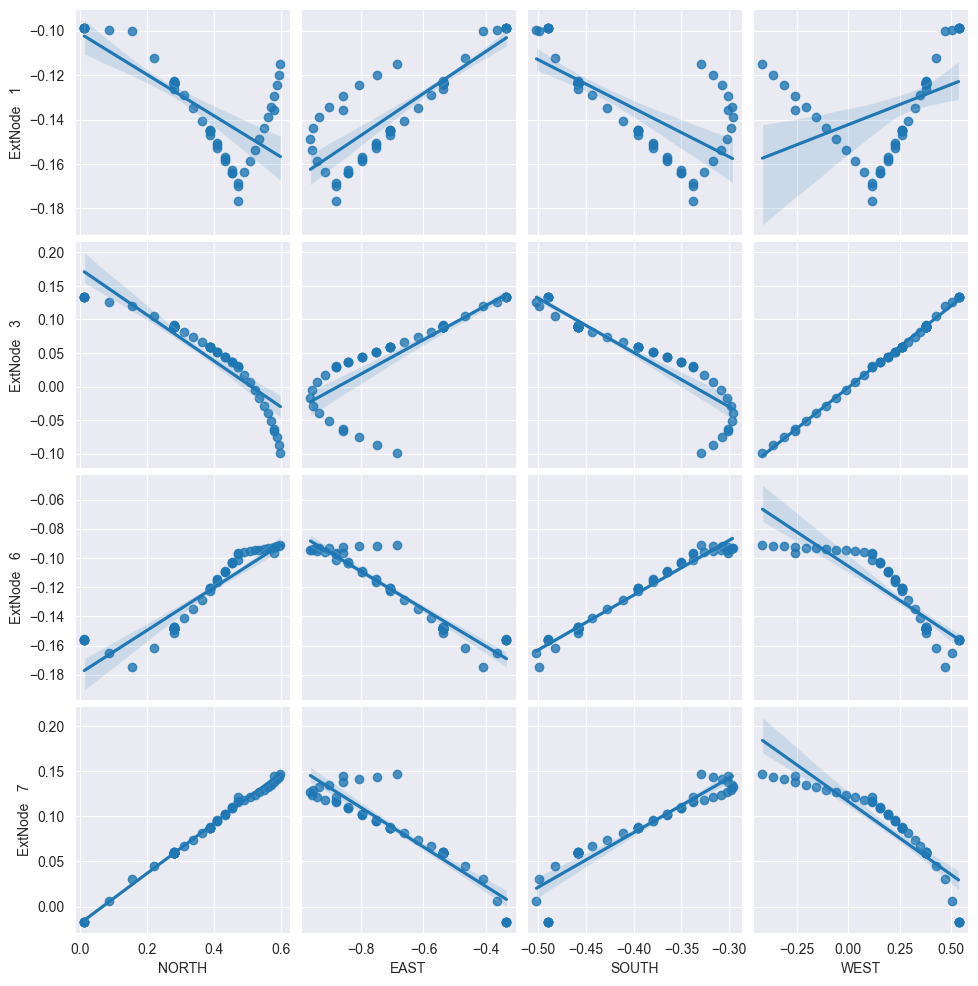

In [490]:
sns.pairplot(df_join.filter(pl.col("Site Wind Direction [deg]") > 250).to_pandas(), x_vars=dir_cols, y_vars=ext_cols, kind="reg")